<a href="https://colab.research.google.com/github/amey-joshi/am/blob/master/p4/m2p_C02_A_Stochastic_Quasi_Newton_Method_for_Non_Rigid_Image_Registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This tutorial is based on the paper [A Stochastic Quasi-Newton Method for Non-rigid Image Registration](https://drive.google.com/drive/folders/1iNk4CD8wlBt0reTZBk6NPLeseIT9EXIV) by Yuchuan Qiao, Zhuo Sun, Boudewijn P.F. Lelieveldt, and Marius Staring. It assumes that the reader has gone over our previous tutorials on image registration. Therefore, it omits an exhaustive discussion of the idea of image registration and basic optimization techniques.

Briefly, image registration involves aligning two images of the same object taken at 1) different orientations, 2) different times or 3) using different sensors. If $I_F$ is a **fixed image**, $I_M$ is the **moving image** and $T_{\boldsymbol{\mu}}$ is a transformation with parameter vector $\boldsymbol{\mu}$ such that $T_{\boldsymbol{\mu}}I_M$ is an approximation of $I_F$ then the image registration problem is to find the **best** such $\boldsymbol{\mu}$. The idea of best is expressed in mathematical terms as the minimum of a certain **cost function** $\mathcal{C}$ that describes the **dissimilarity** between $I_F$ and $T_{\boldsymbol{\mu}}(I_M)$. If $T_{\boldsymbol{\mu}}(I_M)$ is a good approximation to $I_F$ then the cost $\mathcal{C}(I_F, T_\boldsymbol{\mu}(I_M))$ is indeed a minimum. We can express this mathematically as
$$\tag{1}
\hat{\boldsymbol{\mu}} = \mathrm{argmin}_\boldsymbol{\mu}\;\mathcal{C}(I_F, T_\boldsymbol{\mu}(I_M)).
$$
Thus, the image registration problem is at its heart an optimization problem. In the next section we give a brief sketch of the optimization methods that eventually lead us to the stochastic least memory  Broyden–Fletcher–Goldfarb–Shanno (s-LBFGS) method used in this paper.

# Methods
A function has its extremum when its derivative, or gradient if it is a multi-variable function, is zero. Finding an extremum is thus equivalent to finding the root of the derivative (or gradient) function. That is the reason many root finding algorithms find their use in optimization algorithms. Perhaps the oldest algorithm to find roots it the **Newton's method**. If $f$ is a function of $x$ then to find an extremum of $f$ we must find an $x_0$ such that $f^\prime(x_0) = 0$. Thus the problem of finding an extremum of $f$ is identical to finding the root of its derivative. The Taylor expansion of $f$, up to the quadratic terms, is
$$\tag{2}
f(x_k + h) \approx f(x_k) + hf^\prime(x_k) + \frac{h^2}{2}f^{\prime\prime}(x_k).
$$
The approximate form will have a minimum at 
$$\tag{3}
h = -\frac{f^\prime(x_k)}{f^{\prime\prime}(x_k)}.
$$
Therefore, we can update our root to
$$\tag{4}
x_{k+1} = x_k + h = x_k -\frac{f^\prime(x_k)}{f^{\prime\prime}(x_k)}.
$$
When we reach the extremum, $x_{k+1} = x_k$. This idea is generalized to the case when $f$ is a function of more than one variables by replacing $f^\prime(x_k)$ with the gradient $\nabla f(x_k)$ and the reciprocal of the second derivative by the inverse of the Hessian matrix $B_k$. Thus, equation (4) becomes
$$\tag{5}
x_{k+1} = x_k - B_k^{-1}\nabla f(x_k).
$$
A strict implementation of Newton's method involves finding the inverse of the Hessian matrix at every iteration. If the number of variables on which $f$ depends in large then this is prohibitively expensive. In the case of the cost function of a $512 \times 512$ image the number of variables will be $n = 2^{18}$. This is where the **quasi-Newton** methods come into picture. In these methods we do not use the actual hessian matrix but an approximation to it. There a large number of choices of the approximate form of the hessian matrix, each one giving rise to a variant of quasi-Newton method. One of the most popular methods is BFGS, named after its inventors Broyden-Fletcher-Goldfarb-
Shanno. If $H_k = B_k^{-1}$ then the BFGS approximation is
$$\tag{6}
H_{k+1} = V_k^TH_kV_k + \rho_ks_k s_k^T,
$$
where
$$
\begin{eqnarray}
\rho_k &=& (y_k^T s_k)^{-1} \tag{7} \\
V_k &=& I - \rho_k y_k s_k^T \tag{8} \\
s_k &=& \mu_{k+1} - \mu_k \tag{9} \\
y_k &=& g_{k+1} - g_{k} \tag{10},
\end{eqnarray}
$$
$g_k$ being the same as $\nabla f(x_k)$. If $f$ is a function of $n$ variables then the Hessian matrix and its approximation have size $n \times n$. For large $n$ storing the Hessian itself will take up a lot of memory. The **limited memory BFGS** algorithm approximates the hessian further by storing only a few vectors that can reconstruct the hessian. Thus the storage demand drops from $O(n^2)$ to $O(n)$. **Python code** implementing these algorithms is made available for academic use by [J. Bayer, C. Osendorfer, S. Diot-Girard, T. Rückstiess and Sebastian Urban. climin - A pythonic framework for gradient-based function optimization. TUM Tech Report. 2016.](https://github.com/BRML/climin/blob/master/climin/bfgs.py)

If $g_k = \nabla f(x_k)$ and $H_k = B_k^{-1}$ then one can write equation (5) as
$$\tag{11}
x_{k+1} = x_k - \gamma_k H_k g_k,
$$
where we have introduced a 'step size' $\gamma_k$. We thus observe that we really do not need to store the $n \times n$ matrix $H_k$ if we can find a way to estimate the $n$-vector $H_k g_k$. One way to estimate the product $H_k g_k$ is the two-step recursion explained in [Wikipedia](https://en.wikipedia.org/wiki/Limited-memory_BFGS).

# Stochastic quasi-Newton method
Equations (6) to (10) suggest that all the quantities can be readily computed from the pair $\{s_k, y_k\}$, called **curvature points** by the authors. Computing these at each iteration involves all points of the data set. One way to reduce this effort is to work with only a subset of these. For this is how the stochastic gradient descent algorithm works. However the authors believe that the stochastic gradient descent algorithm is inherently noisy and the problem is exacerbated in the case of medical images by the fact that each computation of a 'stochastic' gradient potential involves a different set of voxels.

One way to tide over this problem is:

*   After every $L$ iterations denoise the optimization parameters $\boldsymbol{\mu}$ by averaging them. Use a small random subset $\mathcal{S}_1$ in each of these iterations.
*   Use the average to compute the full Hessian using a random subset $\mathcal{S}_2$ of the data.

The authors adapt this idea to medical images by

*   Using more samples in the $L$ iterations used for updating $\{s_k, y_k\}$.
*   Computing instead of the hessian the difference in gradients. Thus, $y_k = g(\bar{\boldsymbol{\mu}}_I; \mathcal{S}_2) - g(\bar{\boldsymbol{\mu}}_J; \mathcal{S}_2)$. Note that the **same** random subset $\mathcal{S}_2$ of data is used for the computation of both gradients.

The step size $\gamma_k$ in equation (11) is chosen in a manner similar to what we did in the tutorial on adaptive stochastic gradient. That is,
$$\tag{12}
\gamma_k = \frac{\eta a}{(t_k + A)^\alpha},
$$
where $A \ge 1, a > 0$ and $\alpha, \eta \in [0, 1]$. We continue the choice of $\alpha = 1$ made in the tutorial in adaptive stochastic gradient. Refer to the same tutorial for the interpretation of $t_k$ as 'time'. We now present a python function implementing the algorithm. 





# Implementation
We continue to use two binary images to illustrate the idea.

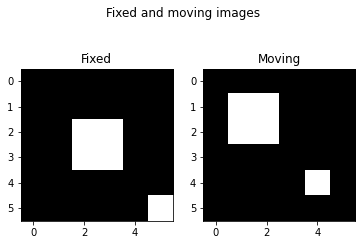

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

f = np.zeros(36)
f[14] = f[15] = f[20] = f[21] =  f[35] = 128
ref = Image.new('1', (6, 6))
ref.putdata(f)

m = np.zeros(36)
m[7] = m[8] = m[13] = m[14] = m[28] = 128
tst = Image.new('1', (6, 6))
tst.putdata(m)

plt.figure()
plt.suptitle('Fixed and moving images')
p1 = plt.subplot(121)
p1.set_title('Fixed')
plt.imshow(ref)

p2 = plt.subplot(122)
p2.set_title('Moving')
plt.imshow(tst)

plt.show()

We now put it all together. Note that we reuse some of our code in the previous tutorial on adaptive stochastic gradient techniques.

In [5]:
# Next cell
x = f - m # This is the "error" between the images.
C = np.array([[36, np.sum(x)], [np.sum(x), np.sum(x**2)]])/36

# Run the previous cells before running this one.
mu_0 = np.array([0.1, 0.1])
L = 3             # After how many iterations will we recompute the gradient.
K = 25            # Maximum number of times we will update the gradient.
x = f - m         # This is the "error" between the images.
n_samples = 6     # Number of samples to compute the stochastic gradient.

# Parameters mentioned in equation (5) of the paper.
theta_0 = 0.05
H_00 = theta_0 * np.eye(len(mu_0))
g_0 = np.ones(len(mu_0))

# We will keep the implementation simple by choosing the step size to be 1.

def compute_approx_g(x, mu):
  g = np.zeros(2)
  for j in range(len(x)):
    # Recall that the data for the fixed image is in the array x
    X = np.array([1, x[j]]) 
    coeff = -2 * ((1 - mu[1]) * x[j] - mu[0])
    g = g + coeff * X
    
  return g

import random

mu_prev = mu_0
H_prev = H_00
g_prev = g_0
m_prev = m

for k in range(K):
  g_sum = np.zeros(2) # The sum of gradients. We will use it for denoising.

  # Select a new set of pixels for computation of each approximate gradient
  S = random.sample(range(0, 36), n_samples)
  for l in range(L):
    mu_curr = mu_prev - np.dot(H_prev, g_prev)
    m_curr = m_prev * mu_curr[0] + mu_curr[1]
    x = m_curr - f
    
    g_curr = compute_approx_g(x, mu_curr)       
    s = mu_curr - mu_prev
    y = g_curr - g_prev

    rho = 1/np.dot(y, s)
    V = np.eye(len(mu_0)) - rho * np.outer(y, s)
    Vt = V.transpose()

    H_prev = np.dot(np.dot(Vt, H_prev), V) + rho * np.outer(s, s)
    g_sum = g_sum + g_prev
    g_prev = g_curr
    mu_prev = mu_curr

  avg_g = g_sum/L
  mu_curr = mu_prev - np.dot(H_prev, avg_g)
  m_curr = m_prev * mu_curr[0] + mu_curr[1]

  x = m_curr - f
  s = mu_curr - mu_prev
  y = avg_g - g_prev

  rho = 1/np.dot(y, s)
  V = np.eye(len(mu_0)) - rho * np.outer(y, s)
  Vt = V.transpose()

  H_prev = np.dot(np.dot(Vt, H_prev), V) + rho * np.outer(s, s)
  g_prev = avg_g
  mu_prev = mu_curr

print(f'Transformation parameters are mu = {mu_curr}')


Transformation parameters are mu = [-0.67889137  1.3275286 ]
